# Librerías

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

## Librerías
import numpy as np
import seaborn as sns
import sys
import cv2 as cv2
import glob
from PIL import Image
import tensorflow as tf
import sys
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import gc
import keras
from sklearn.model_selection import train_test_split
import os


from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import umap
from sklearn.preprocessing import StandardScaler

print(tf.__version__)

In [2]:
## Uso de GPU
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

# Dataset

In [3]:
## Obtener todas las rutas de las imágenes en el dataset
rutas_dataset  = glob.glob('/home/willy98/archivos/Datasets/Micrografías_segmentadas/secas/*/*/*/*.jpg')

## Separar rutas
mask_list = []
image_list = []
for ruta in rutas_dataset:
    ruta_list = ruta.split('/')
    clase = ruta_list[7]
    number = ruta_list[8]
    tipo = ruta_list[9]
    name = ruta_list[10].split('.')[0]
    
    if tipo == 'train':
        image_list.append([name,ruta,clase,number])
    elif tipo == 'mask_bin':
        mask_list.append([name,ruta,clase,number])
    else:
        None

mask_pd = pd.DataFrame(mask_list,columns=['name','route_mask','class','number']).sort_values(by='name')
image_pd = pd.DataFrame(image_list,columns=['name','route_image','class','number']).sort_values(by='name')

routes_dataset = image_pd.merge(mask_pd,on=['name','class','number'],how='left')

routes_dataset.dropna(inplace=True)

routes_dataset = routes_dataset.sample(frac = 1)

print('Imágenes secas:', np.shape(routes_dataset)[0])
print('MF1:', '- secas: ', np.shape(routes_dataset[routes_dataset['class']=='MF1'])[0])
print('MF2:', '- secas: ', np.shape(routes_dataset[routes_dataset['class']=='MF2'])[0])
print('MF3:', '- secas: ', np.shape(routes_dataset[routes_dataset['class']=='MF3'])[0])

char_to_num = {'MF1':'0','MF2':'1','MF3':'2'}

routes_dataset['class'].replace(char_to_num,inplace=True)

routes_dataset

Imágenes secas: 927
MF1: - secas:  378
MF2: - secas:  288
MF3: - secas:  261


,name,route_image,class,number,route_mask
492,IMG_20230711_154345_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,1,1,/home/willy98/archivos/Datasets/Micrografías_s...
703,IMG_20230711_180410_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,1,6,/home/willy98/archivos/Datasets/Micrografías_s...
897,IMG_20230711_222402_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,2,5,/home/willy98/archivos/Datasets/Micrografías_s...
241,IMG_20230707_171125_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,0,3,/home/willy98/archivos/Datasets/Micrografías_s...
440,IMG_20230707_191454_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,0,7,/home/willy98/archivos/Datasets/Micrografías_s...
...,...,...,...,...,...
434,IMG_20230707_191350_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,0,7,/home/willy98/archivos/Datasets/Micrografías_s...
899,IMG_20230711_222415_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,2,5,/home/willy98/archivos/Datasets/Micrografías_s...
852,IMG_20230711_214515_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,2,6,/home/willy98/archivos/Datasets/Micrografías_s...
839,IMG_20230711_212807_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,2,7,/home/willy98/archivos/Datasets/Micrografías_s...


In [4]:
## Establecer el porcentaje de separación
prct_train = 0.8

thold1 = int(np.ceil(prct_train * len(routes_dataset[routes_dataset['class']=='0'])))
thold2 = int(np.ceil(prct_train * len(routes_dataset[routes_dataset['class']=='1'])))
thold3 = int(np.ceil(prct_train * len(routes_dataset[routes_dataset['class']=='2'])))

## Separar por clases para entrenamiento
train_cu1 = routes_dataset[routes_dataset['class'] == '0'][0:thold1]
train_cu2 = routes_dataset[routes_dataset['class'] == '1'][0:thold2]
train_cu3 = routes_dataset[routes_dataset['class'] == '2'][0:thold3]

## tomar las demás imágenes para test
test_cu1 = routes_dataset[routes_dataset['class'] == '0'][thold1:]
test_cu2 = routes_dataset[routes_dataset['class'] == '1'][thold2:]
test_cu3 = routes_dataset[routes_dataset['class'] == '2'][thold3:]

## Cantidad de muestras por clase
print('Clase MF1: train: ',len(train_cu1),', test: ',len(test_cu1))
print('Clase MF2: train: ',len(train_cu2),', test: ',len(test_cu2))
print('Clase MF3: train: ',len(train_cu3),', test: ',len(test_cu3))

Clase MF1: train:  303 , test:  75
Clase MF2: train:  231 , test:  57
Clase MF3: train:  209 , test:  52


In [5]:
### Definir datasets de training y test
# Todas las clases
train_df =  pd.concat([pd.concat([train_cu1,train_cu2]),train_cu3])
test_df = pd.concat([pd.concat([test_cu1,test_cu2]),test_cu3])

# solo una clase
#train_df = train_cu1
#test_df = test_cu1

train_df

,name,route_image,class,number,route_mask
241,IMG_20230707_171125_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,0,3,/home/willy98/archivos/Datasets/Micrografías_s...
440,IMG_20230707_191454_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,0,7,/home/willy98/archivos/Datasets/Micrografías_s...
187,IMG_20230707_164521_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,0,2,/home/willy98/archivos/Datasets/Micrografías_s...
189,IMG_20230707_164535_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,0,2,/home/willy98/archivos/Datasets/Micrografías_s...
294,IMG_20230707_174044_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,0,4,/home/willy98/archivos/Datasets/Micrografías_s...
...,...,...,...,...,...
65,IMG_20230602_220659_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,2,4,/home/willy98/archivos/Datasets/Micrografías_s...
53,IMG_20230602_212339_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,2,3,/home/willy98/archivos/Datasets/Micrografías_s...
818,IMG_20230711_212321_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,2,7,/home/willy98/archivos/Datasets/Micrografías_s...
25,IMG_20230601_152414_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,2,1,/home/willy98/archivos/Datasets/Micrografías_s...


In [6]:
## Crear objetos transformadores
## Para entrenamiento
SEED = 100

img_generator_images = tf.keras.preprocessing.image.ImageDataGenerator(  
    rescale=1./255,      
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)

img_generator_mask = tf.keras.preprocessing.image.ImageDataGenerator(  
    rescale=1./255,      
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)

## Crear objeto generador de imágenes a partir del objeto transformator
## Pra entrenamiento
train_generator_IMAGES = img_generator_images.flow_from_dataframe(
    dataframe=train_df,
    #directory="./train/",
    x_col="route_image",
    y_col="class",
    labels = ['MF1'],
    #labels = ['MF2'],
    subset="training",
    batch_size=64,
    seed=SEED,
    shuffle=True,
    class_mode="sparse" ,
    validation_split=0.2,
    color_mode ="grayscale",
    target_size=(128,128))

train_generator_MASK = img_generator_mask.flow_from_dataframe(
    dataframe=train_df,
    #directory="./train/",
    x_col="route_mask",
    y_col="class",
    labels = ['MF1'],
    #labels = ['MF2'],
    subset="training",
    batch_size=64,
    seed=SEED,
    shuffle=True,
    class_mode="sparse" ,
    validation_split=0.2,
    color_mode ="grayscale",
    target_size=(128,128))

Found 595 validated image filenames belonging to 3 classes.
Found 595 validated image filenames belonging to 3 classes.


In [7]:
X_train_images = []
train_mask = []
label_train_images  = []
label_train_mask = []

batches = 50
cnt = 0

for i in range(batches):
    
    x,y = train_generator_IMAGES.next()

    X_train_images.extend(x)
    label_train_images.extend(y)
    
for i in range(batches):
    
    x,y = train_generator_MASK.next()

    train_mask.extend(x)
    label_train_mask.extend(y)
    
    
print(np.shape(train_mask),np.shape(train_mask))
print(np.array_equal(label_train_mask,label_train_images))

(2975, 128, 128, 1) (2975, 128, 128, 1)
True


1.0 1.0


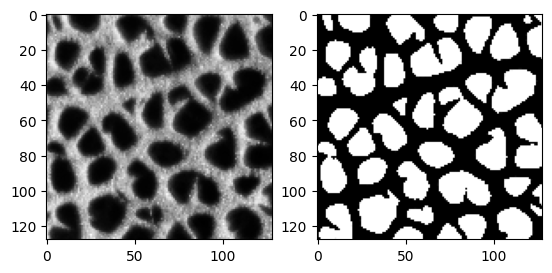

In [8]:
## Visualizar:
n = 0
fig, (ax1, ax2) = plt.subplots(1, 2)
ax2.imshow(train_mask[n],cmap='gray')
ax1.imshow(X_train_images[n],cmap='gray')
print(label_train_mask[n],label_train_images[n])
plt.show()

In [9]:
x_train_images = np.array(X_train_images)

x_train_images = x_train_images.astype('float32')

print('x_train shape:', x_train_images.shape)
print('Number of images in x_train', x_train_images.shape[0])

x_train shape: (2975, 128, 128, 1)
Number of images in x_train 2975


# Modelo

In [17]:
### Arquitectura
class encoder_block(layers.Layer):
    
    ## Inicializar la clase de capa convolucional
    def __init__(self,out_channels,kernel_size=(3, 3)):
        ## conv y bn son las dos capas (que contienen pesos) del bloque/clase
        super(encoder_block, self).__init__()
        self.conv = layers.Conv2D(out_channels,kernel_size, activation='relu', padding='same')
        self.pooling = layers.MaxPooling2D()
        self.bn = layers.BatchNormalization()       
    
    
    ## The call method is the same as the forward method of the block
    def call(self, input_tensor,training = False):
        x = self.conv(input_tensor)
        x = self.pooling(x)
        x = self.bn(x,training = training)           
        
        return x
    
    def call_last_conv_layer(self, input_tensor):
        x = self.conv(input_tensor)
        x = self.pooling(x)
        
        return x
        

    
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
class Encoder(keras.Model):
    
    def __init__(self,name = 'encoder',n_dims=128,**kwargs):
        super(Encoder, self).__init__(name=name, **kwargs)         
        ## Bloque convolucional:
        self.block1 = encoder_block(1024)
        self.block2 = encoder_block(1024)
        self.block3 = encoder_block(512)
        self.block4 = encoder_block(128)
        self.block5 = encoder_block(64)
        self.final_cov = layers.Conv2D(16,(3,3), activation='relu', padding='same')
        self.flattening = layers.Flatten()
        self.z_mean = layers.Dense(n_dims)
        self.z_logvar = layers.Dense(n_dims)
        self.embedding = Sampling()
        
        
        
    def call(self, tensor_input):
        x = self.block1(tensor_input)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.final_cov(x)
        x = self.flattening(x)
        mu = self.z_mean(x)
        logvar = self.z_logvar(x)
        z = self.embedding([mu,logvar])
        
        
        return [mu,logvar,z]
    
    def call_embedding(self, tensor_input):
        x = self.block1(tensor_input)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.final_cov(x)
        
        return x
    

class decoder_block(layers.Layer):
    
    def __init__(self,out_channels,kernel_size=(3,3),size_upsam = (2,2)):
        super(decoder_block,self).__init__()
        self.conv = layers.Conv2D(out_channels,kernel_size, activation='relu', padding='same')
        self.upsam = layers.UpSampling2D(size=size_upsam)  
        self.bn = layers.BatchNormalization()   
        
    def call(self,input_tensor,training = False):
        x = self.conv(input_tensor)
        x = self.upsam(x)
        x = self.bn(x, training = training)
        
        
        return x
    
class Decoder(keras.Model):
    
    def __init__(self,name = 'decoder',**kwargs):
        super(Decoder, self).__init__(name=name, **kwargs)
        self.firts_layer = layers.Dense(8*8*64,activation = 'relu') 
        self.block1 = decoder_block(64)
        self.block2 = decoder_block(32)
        self.block3 = decoder_block(16,size_upsam =(4,4))        
        self.conv = layers.Conv2D(8, (3, 3), activation='relu', padding='same')
        self.final = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')    
        
        
    def call(self, embedding_input):
        embedding_input = self.firts_layer(embedding_input)
        x = tf.reshape(embedding_input,[-1,8,8,64])
        x = self.block1(x)       
        x = self.block2(x) 
        x = self.block3(x)        
        x = self.conv(x)
        out = self.final(x)
        
        return out


class VAE(keras.Model):
    def __init__(self,encoder,decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        ##Variables que guardan paso a paso las pérdidas
        self.kl_loss_tracker = keras.metrics.Mean(name='kl_loss')        
        self.reconstruction_loss_tracker = keras.metrics.Mean(name='reconstruction_loss')
        self.total_loss_tracker = keras.metrics.Mean(name='total_loss')
        
    @property
    def metrics(self):
        return[
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def train_step(self,data):
        with tf.GradientTape() as tape:
            ## Generar embebidos
            z_mean, z_log_var, z = self.encoder(data)
            
            ## Reconstruir embebidos
            reconstruction = self.decoder(z)
            
            ## Normalizar reconstrucciones
            reconstruction /= tf.reduce_max(reconstruction)
            
            ## Calcular la diferencia binaria entre las imágenes de entrada y las reconstrucciones
            
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )         
            
            '''
            reconstruction_loss =tf.reduce_mean(
                tf.reduce_sum( tf.keras.losses.MeanSquaredError()(data, reconstruction)
                             )
            )
            '''
            
            ## Pérdida de kullback leibler
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))            
        
            ## Pérdida total
            total_loss = reconstruction_loss + kl_loss     
            
        ## Calcular los gradientes 
        grads = tape.gradient(total_loss, self.trainable_weights)       

        ## Guardar reconstrucciones en una variable propia del modelo
        self.reconstruction = reconstruction

        ## Calcular gradientes entre los pesos            
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        ## Actualizar la variable de pérdida total
        self.total_loss_tracker.update_state(total_loss)

        ## Actualizar la variable de pérdida de reconstrucción
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)       

        ## Actualizar la variable de pérdida por kull-back
        self.kl_loss_tracker.update_state(kl_loss)       

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(), 
            'kl_loss':self.kl_loss_tracker.result(),
        }

In [18]:
test_array = np.zeros([1,128,128,1])
enc_test = Encoder()
dec_test = Decoder()

embs_test = enc_test.predict(test_array)
rect_test = dec_test.predict(embs_test[2])

print(enc_test.summary())
print(dec_test.summary())


1/1 [==============================] - 0s 226ms/step
Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_block_25 (encoder_b  multiple                 14336     
 lock)                                                           
                                                                 
 encoder_block_26 (encoder_b  multiple                 9442304   
 lock)                                                           
                                                                 
 encoder_block_27 (encoder_b  multiple                 4721152   
 lock)                                                           
                                                                 
 encoder_block_28 (encoder_b  multiple                 590464    
 lock)                                                           
                                                                 
 encod

In [ ]:
enc = Encoder()
dec = Decoder()
vae = VAE(enc,dec)

opt = tf.optimizers.Adam(learning_rate = 0.00001)
#nll = lambda x , rv_x: -rv_x.log_prob(x)
vae.compile(optimizer=opt)


vae.fit(x_train_images, epochs=2000, 
                batch_size=16,
                         callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50)])

Epoch 1/2000


2023-10-05 19:13:59.753754: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x2246a1f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-05 19:13:59.753815: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA TITAN V, Compute Capability 7.0
2023-10-05 19:13:59.760405: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-05 19:13:59.948555: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2023-10-05 19:14:05.538289: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.53GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
202

185/186 [============================>.] - ETA: 0s - loss: 20863.6531 - reconstruction_loss: 20288.4238 - kl_loss: 0.1855

2023-10-05 19:14:38.585773: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.51GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-10-05 19:14:38.585860: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.51GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


186/186 [==============================] - 46s 175ms/step - loss: 20857.4177 - reconstruction_loss: 20280.4512 - kl_loss: 0.1955
Epoch 2/2000
186/186 [==============================] - 29s 155ms/step - loss: 16994.3082 - reconstruction_loss: 15251.3672 - kl_loss: 178.6957
Epoch 3/2000
186/186 [==============================] - 30s 161ms/step - loss: 12821.7417 - reconstruction_loss: 12232.0918 - kl_loss: 230.4881
Epoch 4/2000
186/186 [==============================] - 30s 161ms/step - loss: 11617.4991 - reconstruction_loss: 11180.2246 - kl_loss: 242.8350
Epoch 5/2000
186/186 [==============================] - 30s 161ms/step - loss: 10929.3296 - reconstruction_loss: 10560.0957 - kl_loss: 258.0892
Epoch 6/2000
186/186 [==============================] - 30s 161ms/step - loss: 10593.3780 - reconstruction_loss: 10316.5596 - kl_loss: 216.0723
Epoch 7/2000
186/186 [==============================] - 30s 162ms/step - loss: 10418.3001 - reconstruction_loss: 10229.5078 - kl_loss: 168.1554
Epoch 8

186/186 [==============================] - 29s 156ms/step - loss: 9775.0264 - reconstruction_loss: 9793.8867 - kl_loss: 11.5511
Epoch 116/2000
186/186 [==============================] - 29s 156ms/step - loss: 9819.1289 - reconstruction_loss: 9794.2852 - kl_loss: 11.5275
Epoch 117/2000
186/186 [==============================] - 29s 157ms/step - loss: 9849.6285 - reconstruction_loss: 9868.4863 - kl_loss: 23.5631
Epoch 118/2000
186/186 [==============================] - 29s 156ms/step - loss: 9828.9605 - reconstruction_loss: 9794.0713 - kl_loss: 16.3313
Epoch 119/2000
186/186 [==============================] - 29s 156ms/step - loss: 9834.3451 - reconstruction_loss: 9795.1045 - kl_loss: 14.1938
Epoch 120/2000
186/186 [==============================] - 29s 155ms/step - loss: 9812.0038 - reconstruction_loss: 9817.2578 - kl_loss: 18.5539
Epoch 121/2000
186/186 [==============================] - 29s 157ms/step - loss: 9800.3646 - reconstruction_loss: 9792.7988 - kl_loss: 15.1972
Epoch 122/2000

In [21]:
### Guardar modelo
vae.encoder.save('Models/GVAE_4_encoder_dry_128',save_format="tf")
vae.decoder.save('Models/GVAE_4_decoder_dry_128',save_format="tf")

2023-10-06 12:07:37.868861: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-10-06 12:07:38.432747: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs_0' with dtype float and shape [?,128]
	 [[{{node inputs_0}}]]


INFO:tensorflow:Assets written to: Models/GVAE_4_encoder_dry_128/assets


INFO:tensorflow:Assets written to: Models/GVAE_4_encoder_dry_128/assets
2023-10-06 12:07:39.354953: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,?]
	 [[{{node inputs}}]]
2023-10-06 12:07:39.397834: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,?]
	 [[{{node inputs}}]]
2023-10-06 12:07:39.438847: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'input

INFO:tensorflow:Assets written to: Models/GVAE_4_decoder_dry_128/assets


INFO:tensorflow:Assets written to: Models/GVAE_4_decoder_dry_128/assets
